# Packages

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Test of stationarity
from statsmodels.tsa.stattools import adfuller

# Linear Optimization
from scipy.optimize import minimize

# Functions

In [58]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat


# Download and clean data

In [59]:
DATA_PATH = "/Users/antoine/Documents/GitHub/Allocation_de_portefeuille_sous_contrainte_ESG/data/StockPrice_JPM_AAPL_BP.xlsx"

In [60]:
df = pd.read_excel(DATA_PATH, sheet_name=None)
df_aggregated = df_of_aggregated_data(df)
df_aggregated_in_datetime = convert_index_to_datetime(df_aggregated)
df_clean = transform_df_with_str_values_into_float(df_aggregated_in_datetime, columns_to_change = df_aggregated_in_datetime.columns.drop('Ticker'))

In [61]:
df_clean

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
1985-01-01,0.130022,0.138951,0.124442,0.129464,0.100314,6366416000,AAPL
1985-02-01,0.129464,0.137277,0.110491,0.110491,0.085613,4733388800,AAPL
1985-03-01,0.110491,0.116071,0.092634,0.098772,0.076533,4615587200,AAPL
1985-04-01,0.098772,0.102679,0.087612,0.094866,0.073506,2868028800,AAPL
1985-05-01,0.094866,0.099330,0.075335,0.077567,0.060102,4639129600,AAPL
...,...,...,...,...,...,...,...
2023-07-01,146.190002,159.380005,141.440002,157.960007,155.733475,231241600,JPM
2023-08-01,157.429993,158.000000,145.460007,146.330002,145.258163,169302400,JPM
2023-09-01,146.089996,150.250000,142.649994,145.020004,143.957764,172196500,JPM


# Plot index evolution

In [62]:
VALUE_TO_PLOT = 'Adj Close'
BEGIN_DATE = '2020-01-01'
END_DATE = '2023-12-01'

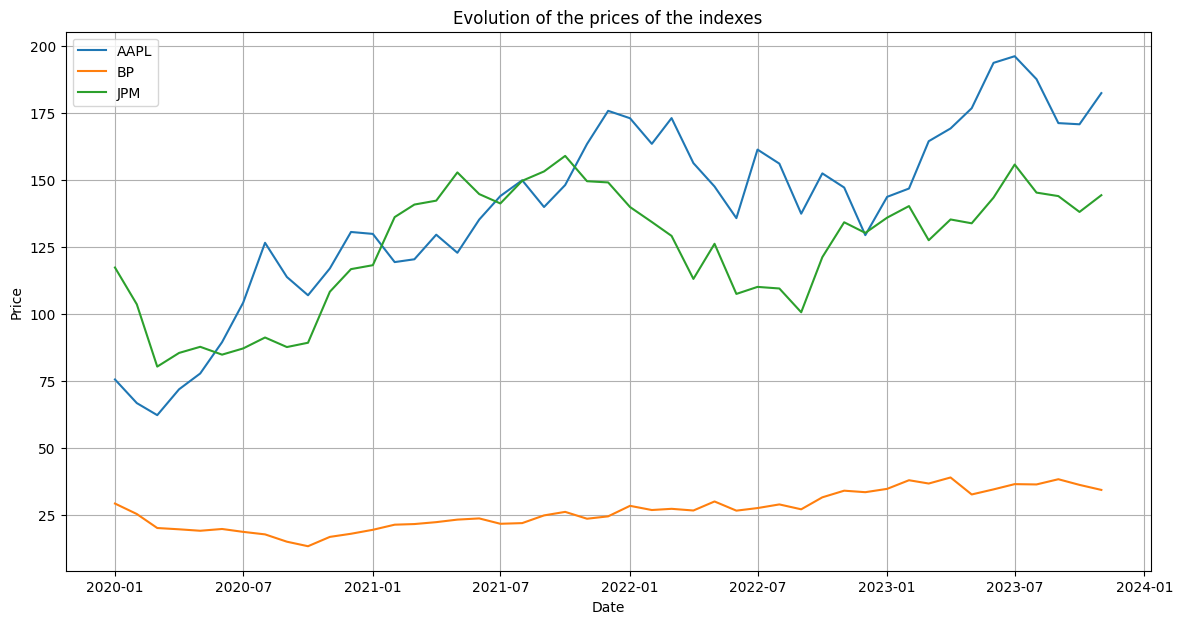

In [63]:
df_cropped = crop_dataframe(df_clean, BEGIN_DATE, END_DATE, all_dates=False)
# df_cropped = crop_dataframe(df_clean, all_dates=True)

table = df_cropped[[VALUE_TO_PLOT,'Ticker']].pivot(columns='Ticker')
table.columns = table.columns.droplevel(0)


plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

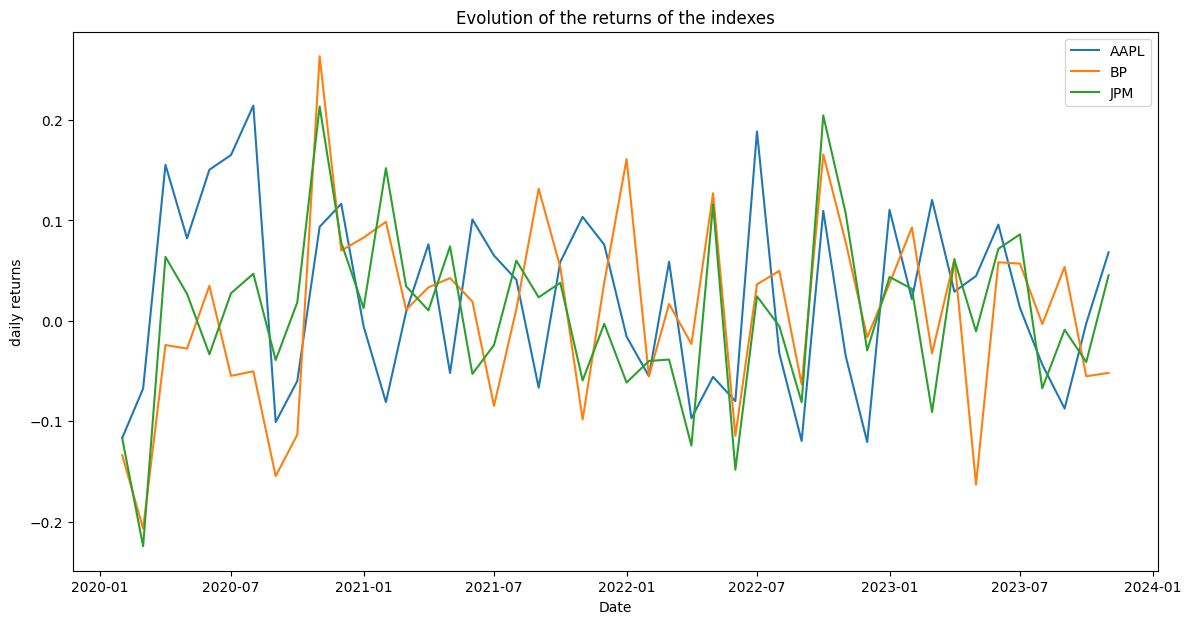

In [64]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Efficient frontier representation

## Test the stationarity of the returns

In [65]:
# For testing stationarity
P_VALUE = 0.01

In [66]:
Y = returns+1
Y_full = Y.iloc[1:]

for index in Y.columns:
    # ADF Test for Stationarity
    result = adfuller(Y_full[index].values, autolag='AIC')

    # Extract and print the results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('__________________________')
    print(f'Stationarity test for {index[1]} index')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= P_VALUE:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely stationary (reject the null hypothesis of non-stationarity).')
    else:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely non-stationary (fail to reject the null hypothesis).')

__________________________
Stationarity test for A index
ADF Statistic: -5.704321048698342
p-value: 7.54946618390237e-07
Critical Values:
   1%: -3.5885733964124715
   5%: -2.929885661157025
   10%: -2.6031845661157025
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for P index
ADF Statistic: -6.491446918007026
p-value: 1.2237879223039011e-08
Critical Values:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for P index
ADF Statistic: -3.1219674473224615
p-value: 0.024969637170898125
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338
Then for a p-value of 0.01, the time series is likely non-stationary (fail to reject the null hypothesis).


## Empirical moments

In [67]:
TIME_T = END_DATE

In [68]:
mu_hat = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
mu_hat

array([1.02328895, 1.0077867 , 1.00802592])

In [69]:
omega_hat =get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
omega_hat

array([[0.1232812 , 0.02099665, 0.03811503],
       [0.02099665, 0.13117813, 0.08227432],
       [0.03811503, 0.08227432, 0.10712891]])

# Efficient Frontier: Gamma Markowitz

In [ ]:
N_ASSETS = 3

In [70]:
def objective(weights, gamma, returns, cov_matrix):
    """_summary_

    Args:
        weights (_type_): Column vector of the weights
        gamma (_type_): Inverse of the risk aversion parameter
        returns (_type_):  Column vector of the expected returns
        cov_matrix (_type_): Matrix of covariance

    Returns:
        _type_: _description_
    """
    x_star = 1/2 * weights.T @ cov_matrix @ weights - gamma * weights.T @ returns
    return x_star


def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1


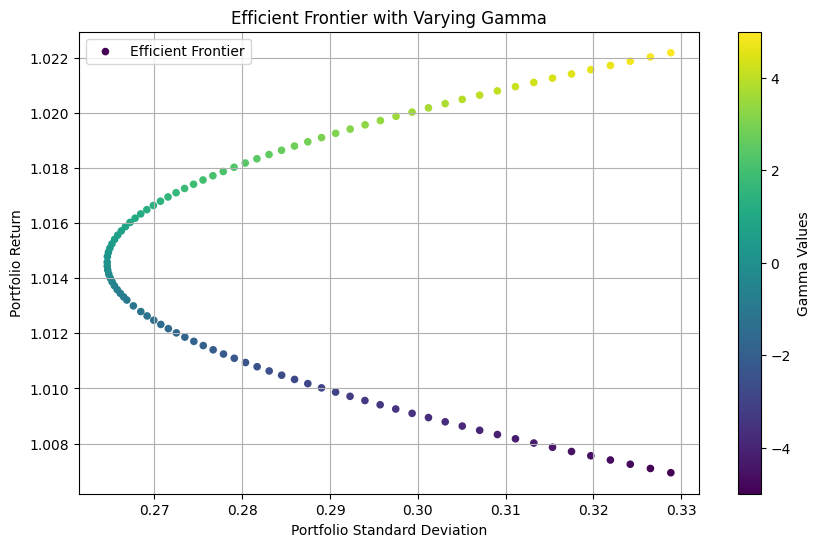

In [124]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)]* N_ASSETS # possession of asset in [-1, 1]

# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Set gamma values
gamma_values = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

# Lists to store results
portfolio_returns = []
portfolio_std_devs = []
weights_gamma = []
objective_values = []

# Solve the problem for different values of gamma
for gamma_val in gamma_values:
    result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds)

    # Save results
    weights_gamma.append(list(result.x))
    portfolio_returns.append(np.dot(mean_returns, result.x))
    portfolio_std_devs.append(np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))))
    objective_values.append(-result.fun)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_std_devs, portfolio_returns, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.title('Efficient Frontier with Varying Gamma')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()



# The Tangent Portfolio

In [167]:
# propostion of risk-free asset in the portfolio
ALPHA = 0.9
# risk-free rate
RISK_FREE_RATE = 0.95
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

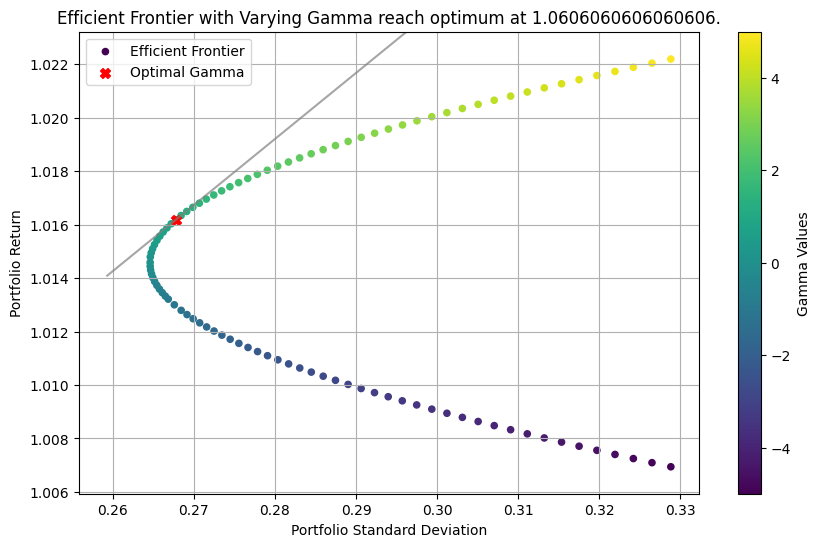

In [196]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]

# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Lists to store results
weights_gamma = []
mu_x, mu_y = [], []
sigma_x, sigma_y = [], []
objective_values = []

# Solve the problem for different values of gamma
for gamma_val in GAMMA_VALUES:
    result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds)
    # Save results
    weights_gamma.append(list(result.x))
    mu = np.dot(mean_returns, result.x)
    mu_x.append(mu)
    mu_y.append((1-ALPHA) * RISK_FREE_RATE + ALPHA * mu) 

    sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
    sigma_x.append(sigma)
    sigma_y.append(ALPHA * sigma)

    objective_values.append(-result.fun)


tangente_theta = [(a - RISK_FREE_RATE)/ b for a, b in zip(mu_y, sigma_y)]
tangente_index = np.argmax(tangente_theta)
gamma_tangent = GAMMA_VALUES[tangente_index]
mu_x_tangent = mu_x[tangente_index]
sigma_x_tangent = sigma_x[tangente_index]


# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(sigma_x, mu_x, s=20, c=GAMMA_VALUES, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
# plot the tangent portfolio
abscisses = [min(sigma_x)*0.98, max(sigma_x)]
ordonnées = [RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * min(sigma_x)*0.98,
            RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * max(sigma_x)]
plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')
plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent}.')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.ylim((min(portfolio_returns)*0.999, max(portfolio_returns)*1.001))
plt.show()



**Comment**: How to find the optimal alpha ?

# ESG Constraints

In [219]:
# Sustainalytics scores [APPL, BP, JPM] -> the smaller, the better
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3]
# Score max
MAX_SCORE = 25

In [220]:
def constraint_ESG_max(x_weights):
    return np.dot(SUSTAINALYTICS_SCORES, x_weights) - MAX_SCORE

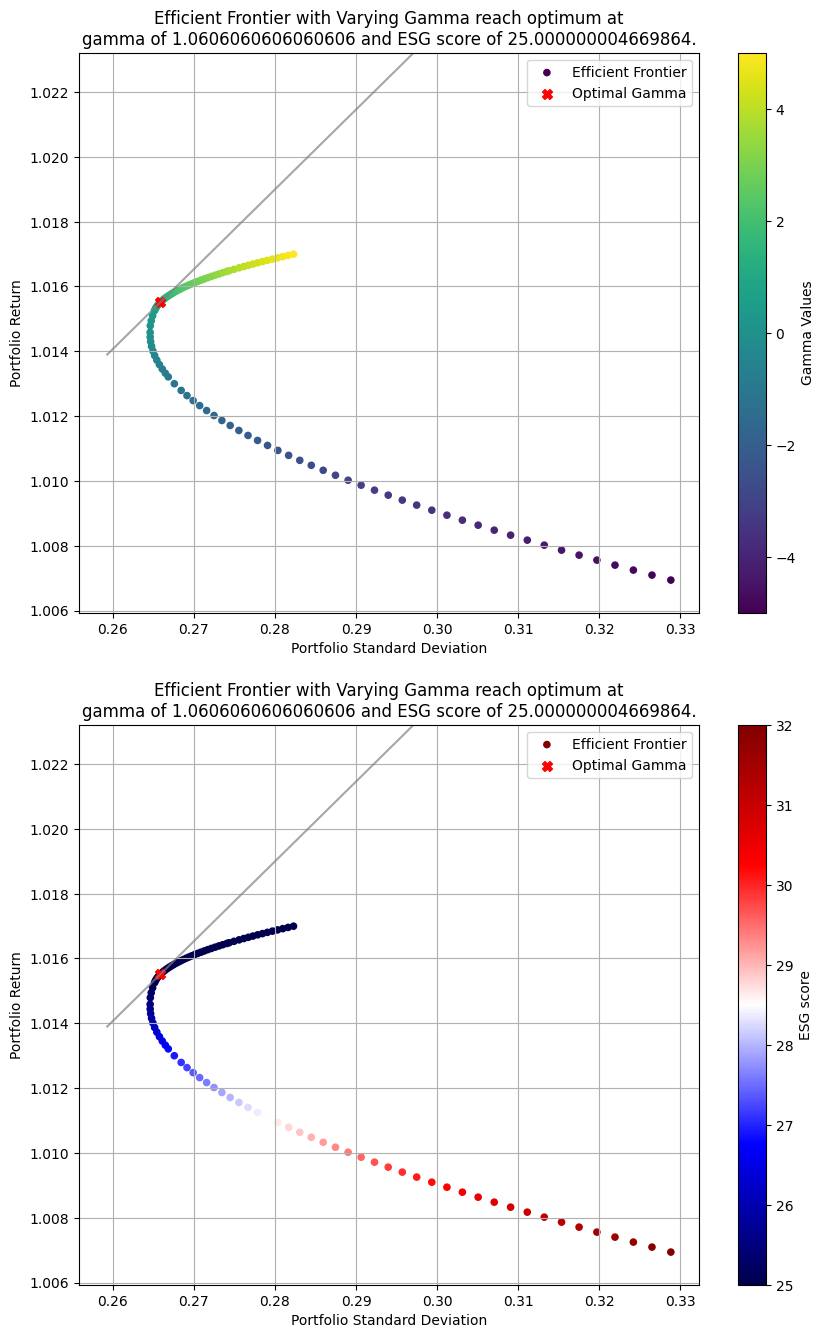

In [221]:

# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}, # fully invested portfolio
               {'type': 'ineq', 'fun':constraint_ESG_max}) # ESG constraint

bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]


# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Lists to store results
weights_gamma = []
mu_x, mu_y = [], []
sigma_x, sigma_y = [], []
objective_values = []
score_esg = []

# Solve the problem for different values of gamma
for gamma_val in GAMMA_VALUES:
    result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds)
    # Save results
    weights_gamma.append(list(result.x))
    mu = np.dot(mean_returns, result.x)
    mu_x.append(mu)
    mu_y.append((1-ALPHA) * RISK_FREE_RATE + ALPHA * mu) 

    sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
    sigma_x.append(sigma)
    sigma_y.append(ALPHA * sigma)

    objective_values.append(-result.fun)

    score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))


tangente_theta = [(a - RISK_FREE_RATE)/ b for a, b in zip(mu_y, sigma_y)]
tangente_index = np.argmax(tangente_theta)
gamma_tangent = GAMMA_VALUES[tangente_index]
mu_x_tangent = mu_x[tangente_index]
sigma_x_tangent = sigma_x[tangente_index]
score_esg_tangent = score_esg[tangente_index]


# Plot the efficient frontier
plt.figure(figsize=(10, 16))
#-- colorbar with gamma values
plt.subplot(2, 1, 1)
plt.scatter(sigma_x, mu_x, s=20, c=GAMMA_VALUES, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
# plot the tangent portfolio
abscisses = [min(sigma_x)*0.98, max(sigma_x)]
ordonnées = [RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * min(sigma_x)*0.98,
            RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * max(sigma_x)]
plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')
plt.title(f'Efficient Frontier with Varying Gamma reach optimum at\ngamma of {gamma_tangent} and ESG score of {score_esg_tangent}.')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.ylim((min(portfolio_returns)*0.999, max(portfolio_returns)*1.001))

#-- colorbar with gamma values
plt.subplot(2, 1, 2)
plt.scatter(sigma_x, mu_x, s=20, c=score_esg, cmap='seismic', label='Efficient Frontier')
plt.colorbar(label='ESG score')
plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
# plot the tangent portfolio
abscisses = [min(sigma_x)*0.98, max(sigma_x)]
ordonnées = [RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * min(sigma_x)*0.98,
            RISK_FREE_RATE + (mu_x_tangent - RISK_FREE_RATE) / sigma_x_tangent * max(sigma_x)]
plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')
plt.title(f'Efficient Frontier with Varying Gamma reach optimum at\ngamma of {gamma_tangent} and ESG score of {score_esg_tangent}.')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.ylim((min(portfolio_returns)*0.999, max(portfolio_returns)*1.001))
plt.show()

**Comment**: Same question about how to get the alphas.